In [1]:
import h5py
import numpy as np
import tensorflow as tf 
import keras
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dropout, Dense, concatenate, BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def splitSamples(data, label, train_size):

    unique_classes = np.unique(label)  #获取唯一的类别标签
    precentage = train_size
    
    #初始化训练集和测试集
    trainData = []
    trainLabel = []
    testData = []
    testLabel = []

    #对每个类别进行遍历
    for i in unique_classes:
        #找到标签中当前类别的索引
        index = np.where(label == i)[0]
        
        #随机打乱索引顺序
        np.random.shuffle(index)

        #得到训练样本数量
        num_train = int(precentage * len(index))    #使用int得到截断值

        #当前类别的索引中随机抽样（预设大小）作为训练集
        index_train = index[:num_train]
        #剩余的作为测试集
        index_test = index[num_train:]

        #将训练集数据和标签添加到列表中
        trainData.extend(data[index_train, :])
        trainLabel.extend(label[index_train])
        
        #将测试集数据和标签添加到列表中
        testData.extend(data[index_test, :])
        testLabel.extend(label[index_test])
    
    
    #将训练集和测试集转换为 numpy 数组并返回
    trainData = np.array(trainData)
    trainLabel = np.array(trainLabel).reshape(-1, 1)
    testData = np.array(testData)
    testLabel = np.array(testLabel).reshape(-1, 1)


    #将抽样后的数据和标签转换为numpy数组并返回
    return trainData, trainLabel, testData, testLabel


In [3]:
import h5py
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time 

#导入之前得到的图像数据
file = h5py.File('DB2_S1_image_200_0.h5','r')
imageData   = file['imageData'][:]
imageLabel  = file['imageLabel'][:]
file.close()

#将数据和标签分割成测试集和训练集
trainData, trainLabel, testData, testLabel = splitSamples(imageData, imageLabel, train_size=0.8)


跑模型前的数据预处理阶段     
x:data   
y:label

In [4]:
"""
在tensorflow中，做卷积时需要将数据变成四维的格式
四个维度为：（数据数量，图片高度，图片宽度，图片通道数）
批量图像数据，数组的形状为[num_images, image_length, num_channels, 1]
其中1指的是灰度图像，3则是rgb彩色图像
"""
#对数据升维
trainData = np.expand_dims(trainData,axis=3)
testData = np.expand_dims(testData,axis=3)

"""
独热编码能够将分类标签转换为数值形式（通常是0和1），使得模型能够处理标签信息
不使用独热编码而是直接使用整数标签，模型可能会错误地认为标签的数值大小有某种含义；
即认为“3”比“2”更优先，这可能会导致学习过程出现偏差
"""
#将训练集和测试集的标签转为独热编码one-hot
trainLabel = tf.keras.utils.to_categorical(trainLabel)
testLabel = tf.keras.utils.to_categorical(testLabel)



In [5]:
#建立CNN模型
def CNN(input_shape, classes): 
    #定义输入层图像数据形状，不包含数据数量，仅图片高度，图片宽度，图片通道数
    img_inputs = keras.Input(input_shape)

    #第一层卷积
    #卷积层参数：过滤器数量，卷积核大小，步长，填充方式，激活函数，本层名称
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', name='c1')(img_inputs)
    x = MaxPooling2D(pool_size = (2,2),strides=None, padding='valid', name='pool1')(x)

    #第二层卷积
    x = Conv2D(filters=64, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu', name='c2')(x)
    x = MaxPooling2D(pool_size = (2,2),strides=None, padding='valid', name='pool2')(x)

    x = Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', name='c4')(x)
    x = MaxPooling2D(pool_size = (2,2),strides=None, padding='valid', name='pool4')(x)

    # 展平特征图，将特征图展平为一维向量。
    x = Flatten(name='flatten')(x)

    #第一次全连接层
    #使用dropout丢弃50%，减少过拟合
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu',name = 'dense1')(x)
    
    #第二次丢弃
    x = Dropout(0.5)(x)
    #输出层，使用softmax激活函数进行多分类预测，得到概率分布的预测
    x = Dense(classes, activation='softmax',name = 'dense2')(x)

    model = Model(inputs=img_inputs, outputs=x, name='CNNmodel')
    return model

model = CNN(input_shape = (200, 12, 1), classes = 49)
model.summary()

Model: "CNNmodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 12, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c1 (Conv2D)                     │ (None, 200, 12, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c2 (Conv2D)                     │ (None, 100, 6, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c4 (Conv2D)                     │ (None, 50, 3, 128)     │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 25, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 49)             │         6,321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 638,065 (2.43 MB)

 Trainable params: 638,065 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 编译模型
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
start_time = time.time()

# 训练模型
'''model参数：
verbose————日志显示模式，0 表示不在标准输出流输出日志信息，
                     1 表示输出进度条记录，
                     2 表示每个 epoch 输出一行记录。'''
history = model.fit(trainData, trainLabel, epochs=300, batch_size=280)

Epoch 1/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 354ms/step - accuracy: 0.0276 - loss: 3.8783
Epoch 2/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - accuracy: 0.0841 - loss: 3.5447
Epoch 3/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.1760 - loss: 2.9839
Epoch 4/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 404ms/step - accuracy: 0.2673 - loss: 2.6055
Epoch 5/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 415ms/step - accuracy: 0.3233 - loss: 2.3347
Epoch 6/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 396ms/step - accuracy: 0.3685 - loss: 2.1338
Epoch 7/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/step - accuracy: 0.4061 - loss: 1.9935
Epoch 8/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 322ms/step - accuracy: 0.4328 - loss: 1.8931
Epoch 9/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 331ms/step - accuracy: 0.4641 - loss: 1.7288
Epoch 10/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - accuracy: 0.4968 - loss: 1.6290
Epoch 11/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step - accuracy: 0.5170 - loss: 1.5595
Epoch 12/300
34/34 ━━━━━━━━━━━

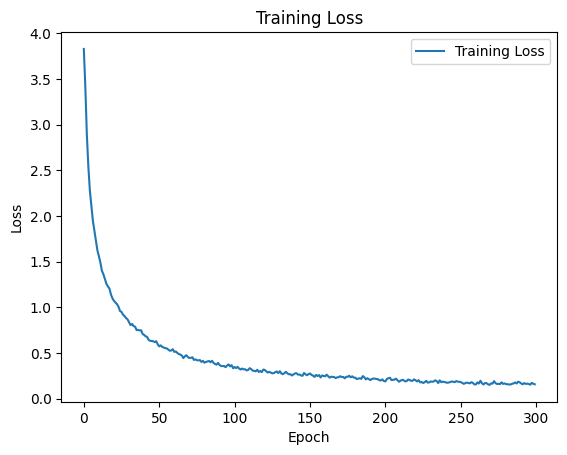

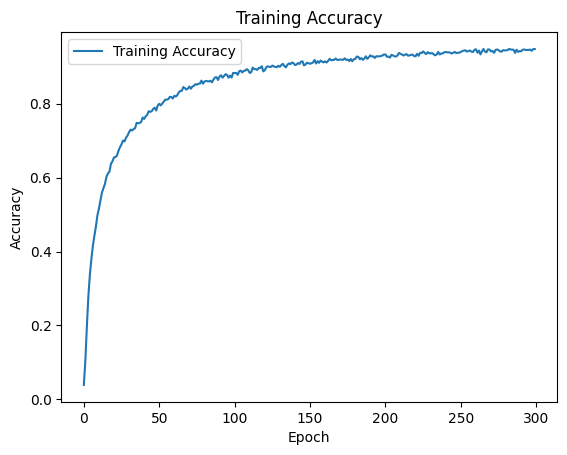

298/298 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 1.0000 - loss: 0.0021
Train accuracy: 1.0
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7122 - loss: 1.9259
Test Loss = 1.5563530921936035
Test Accuracy = 0.7234927415847778
训练模型花费的时间: 5076.66 秒


In [7]:
# 绘制训练损失和验证损失曲线
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练准确率和验证准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 评估模型
train_loss, train_acc = model.evaluate(trainData, trainLabel)
print('Train accuracy:', train_acc)

# 使用模型进行预测
predictions = model.evaluate(testData, testLabel)
print("Test Loss = " + str(predictions[0]))
print("Test Accuracy = " + str(predictions[1]))
print('训练模型花费的时间: %.2f 秒' % (time.time() - start_time))

In [8]:
import json

# 训练模型
# 将 history 转换为字典
history_dict = history.history

# 保存为 JSON 文件
with open('history1-s1.json', 'w') as json_file:
    json.dump(history_dict, json_file)